# CARTE-Enbridge Bootcamp
#### Lab 2-1

# Introduction to TensorFlow

In this lab, we will go over the basics of using TensorFlow to build and train a neural network. TensorFlow is one of the two most popular deep learning frameworks (the other being PyTorch). It is developed by Google and is used in many of their products. 

Using the sub-module Keras, we will build a simple neural network to classify images of handwritten digits from the MNIST dataset.

First, we will import TensorFlow and check the version:

In [1]:
# Import TensorFlow
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print("Using TensorFlow version", tf.__version__)

# Use GPU, if available
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    print("GPU device not found")
else:
    print(f"Found GPU at: {device_name}")

2023-11-07 16:19:40.947294: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-07 16:19:40.977371: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow version 2.13.1
Found GPU at: /device:GPU:0


2023-11-07 16:19:42.405492: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 16:19:42.423555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 16:19:42.423712: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Now we will download the MNIST dataset. Keras provides a convenient function for this. The dataset is already split into training and test sets. We will use the training set to train the model and the test set to evaluate the model's performance on unseen data.

In [2]:
# Download and prepare the MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Before we move forward, it's always helpful to visualize our data to get a sense of what we're working with. Let's display a few of the images from the training set along with their corresponding labels:

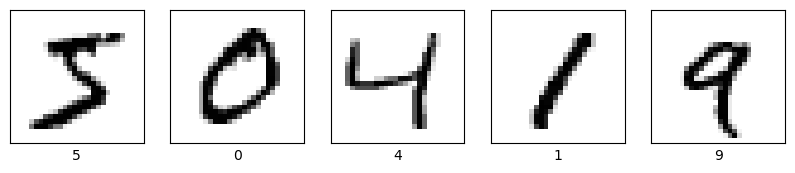

In [3]:
# Visualize the first five images from the training dataset
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

Let's establish some basic information about our dataset, while we're at it:

In [4]:
input_shape = x_train[0].shape
num_classes = len(set(y_train))
print("There are", num_classes, "classes in our dataset")
print("The shape of each image is", input_shape)

There are 10 classes in our dataset
The shape of each image is (28, 28)


When working with neural networks, it is important to normalize the data so that the values all fall between 0 and 1. This is done by dividing each value by the maximum value in the dataset, which is 255 in the case of the MNIST dataset. 

We will also one-hot encode the labels. One-hot encoding is a process where we replace each label with a vector of length equal to the number of possible classes. It's called 'one-hot' because only one of the values in the vector is 1 (aka 'hot'), and the rest are 0.

Part of the reason we do this here is that even though the labels are numbers, they are not ordinal. That is, the fact that the label for a 3 is greater than the label for a 2 does not mean that a 3 is more similar to a 2 than it is to a 4. In fact, the labels are categorical, not numerical. One-hot encoding allows us to treat the labels as categorical, which is important for the loss function we will use later on.
 
This means that we will convert the labels from a single number to a vector whose length is equal to the number of possible classes. The vector will be all 0s except for the index corresponding to the label, which will be 1. For example, if the label is 3, the one-hot encoded label will be [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

In [5]:
# Normalize the data so that the values all fall between 0 and 1
x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

In [6]:
# One-hot encode the labels
print(f"Before one-hot encoding: {y_train[0]}")
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print(f"After one-hot encoding:\n {y_train[0]}")

Before one-hot encoding: 5
After one-hot encoding:
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


The last thing we will do before getting to building our actual model is reshape our input. The images in the MNIST dataset are 28x28 pixels, but we need to flatten them into a single vector of length 784 in order to feed them into our neural network. Later on in the lab, we'll look at a neural network that can accept a 2D image, but for now we will keep it simple. We will do this using the reshape() function.

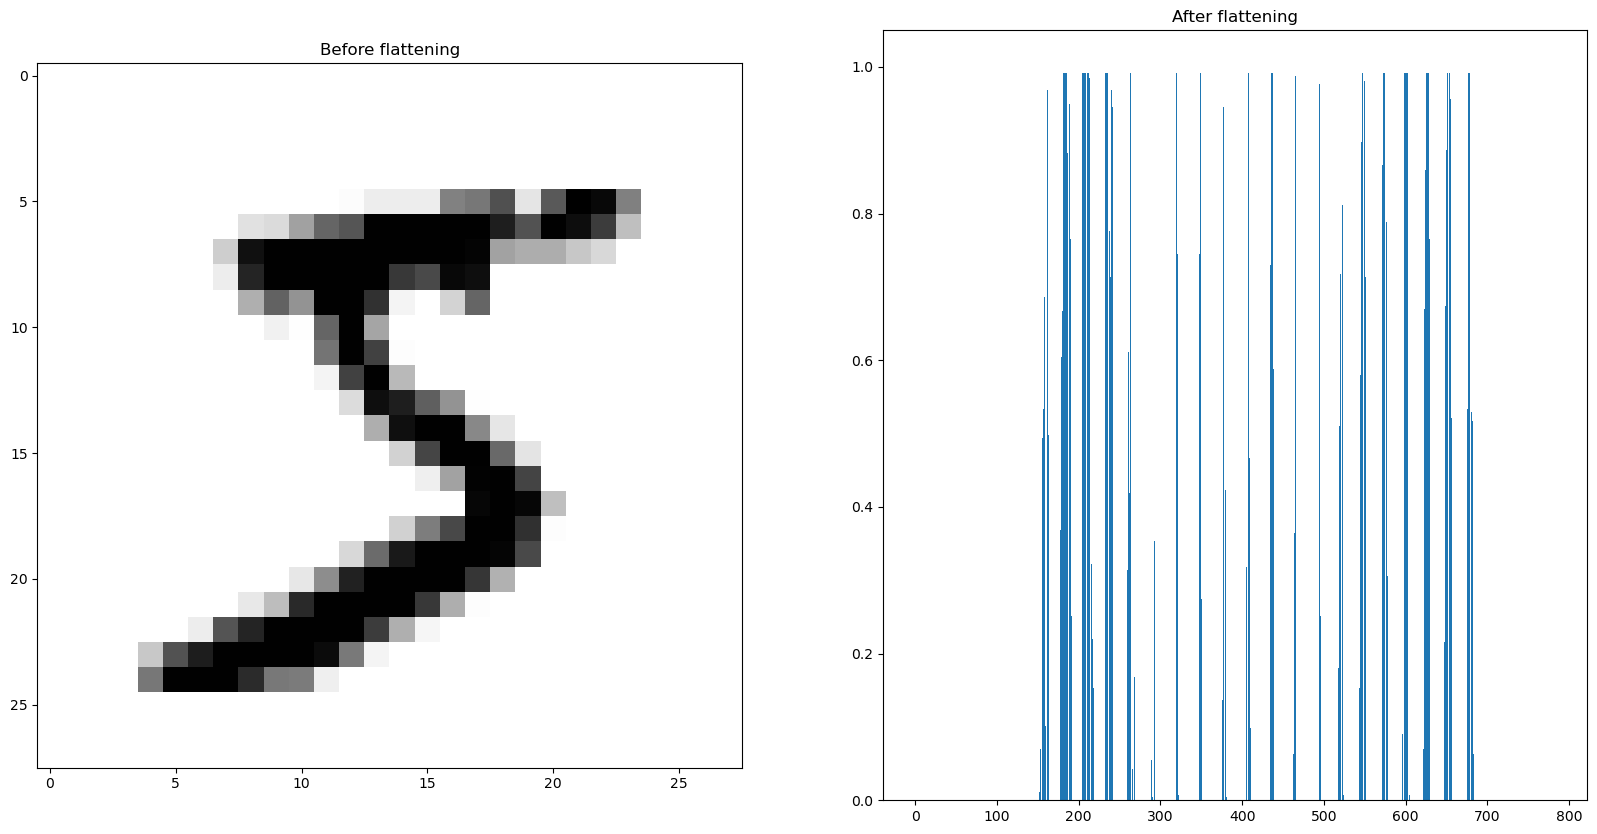

In [7]:
# Flatten the input images
x_train_flattened = x_train.reshape(60000, 28 * 28)
x_test_flattened = x_test.reshape(10000, 28 * 28)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(x_train[0], cmap=plt.cm.binary)
ax[0].set_title("Before flattening")
ax[1].bar(range(28 * 28), x_train_flattened[0])
ax[1].set_title("After flattening")
plt.show()

Okay, now we're ready to build our model! The Keras Sequential API makes this very easy. We just define one layer of our neural network at a time, starting with the input layer. The first layer we add must specify the input shape, which is (28*28,) in our case. 

We will also be using two activation functions we haven't seen before - inside the network, we will use ReLU, and at the end we will use Softmax. ReLU stands for Rectified Linear Unit, and it is defined as f(x) = max(0, x). It is a very simple function, but it is very effective in neural networks. 

Softmax is a function that takes a vector of numbers and outputs a vector of the same length, where each value is between 0 and 1 and the sum of the values is 1. It is often used as the activation function for the output layer of a neural network, because it allows us to interpret the output as a probability distribution over the possible classes.

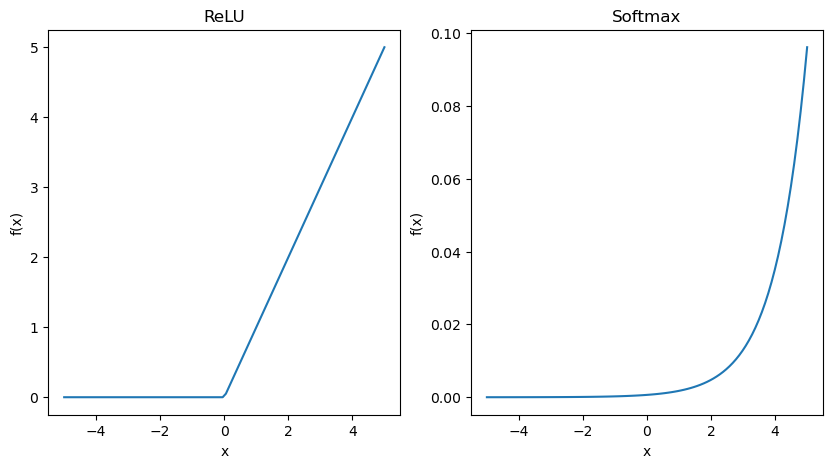

In [8]:
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Plot the ReLU function
x = np.linspace(-5, 5, 100)
ax[0].plot(x, np.maximum(0, x))
ax[0].set_title("ReLU")
ax[0].set_xlabel("x")
ax[0].set_ylabel("f(x)")
# Plot the softmax function
ax[1].plot(x, np.exp(x) / np.sum(np.exp(x)))
ax[1].set_title("Softmax")
ax[1].set_xlabel("x")
ax[1].set_ylabel("f(x)")
plt.show()

In [9]:
# First, define the input to the neural network
input = keras.layers.Input(shape=(28 * 28,)) # Aka (784,)

In [10]:
# Next, define the first hidden layer
hidden1 = keras.layers.Dense(128, activation="relu")(input) # 128 neurons, ReLU activation

2023-11-07 16:19:50.392183: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 16:19:50.392500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 16:19:50.392630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
# Next, define the second hidden layer
hidden2 = keras.layers.Dense(64, activation="relu")(hidden1) # 64 neurons, ReLU activation

In [12]:
# Finally, define the output layer
output = keras.layers.Dense(10, activation="softmax")(hidden2) # 10 neurons, softmax activation

In [13]:
# Now we can define the model, specifying the input and output layers
model = keras.models.Model(inputs=input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Visualize the model
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


It really is that easy! Now we just need to compile the model, specifying the optimizer, loss function, and metrics we want to use. We will use the standard stochastic gradient descent optimizer, the categorical cross-entropy loss function, and the accuracy metric. We use categorical cross-entropy because we have more than two classes. If we had only two classes, we would use binary cross-entropy.

In [15]:
optimizer = "sgd" # Stochastic gradient descent - the foundation of most neural network optimizers
loss = "categorical_crossentropy" # The loss function we will use to train the model - categorical cross-entropy for more than two classes
metrics = ["accuracy"] # The metric we will use to evaluate the model - accuracy is the proportion of correct predictions

In [16]:
# Compile the model
model.compile(
    optimizer=optimizer, 
    loss=loss, 
    metrics=metrics
)

Now we can train the model. We just need to specify the training data, the number of epochs, and the batch size. The batch size is the number of training examples that are fed into the model at once. The number of epochs is the number of times the model will see the entire training set.

In [17]:
# Train the model
model.fit(x_train_flattened, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5


2023-11-07 16:19:54.338710: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-07 16:19:54.365307: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563e635a49d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-07 16:19:54.365331: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-11-07 16:19:54.370921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2023-11-07 16:19:54.380585: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-07 16:19:54.407813: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1688/1688 [==============================] - 5s 3ms/step - loss: 0.6620 - accuracy: 0.8268 - val_loss: 0.2806 - val_accuracy: 0.9237
Epoch 2/5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3071 - accuracy: 0.9115 - val_loss: 0.2241 - val_accuracy: 0.9382
Epoch 3/5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2551 - accuracy: 0.9255 - val_loss: 0.1887 - val_accuracy: 0.9492
Epoch 4/5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2210 - accuracy: 0.9364 - val_loss: 0.1688 - val_accuracy: 0.9553
Epoch 5/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.1950 - accuracy: 0.9439 - val_loss: 0.1516 - val_accuracy: 0.9603


At the end of each epoch, the model will evaluate its performance on the validation set - this is a held out part of our training data that allows us to monitor how well the model is training. It gives us an idea of how well the model will generalize to unseen data. But we still need to evaluate the model on the test set to get a final measure of its performance:

In [18]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test_flattened, y_test)
print(f"Test loss: {loss:.2f}")
print(f"Test accuracy: {accuracy*100:.2f}%")

313/313 [==============================] - 0s 1ms/step - loss: 0.1787 - accuracy: 0.9472
Test loss: 0.18
Test accuracy: 94.72%


That is very good! Let's take a look at some of the predictions the model made:

313/313 [==============================] - 0s 884us/step


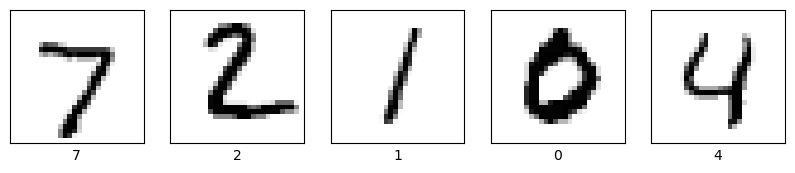

In [19]:
# Visualize the first 5 correct predictions
import numpy as np

predictions = model.predict(x_test_flattened)
correct_indices = np.nonzero(
    np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)
)[0]
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[correct_indices[i]].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(np.argmax(predictions[correct_indices[i]]))
plt.show()

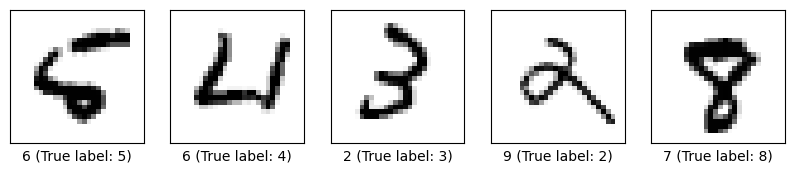

In [20]:
# Visualize the first 5 incorrect predictions
incorrect_indices = np.nonzero(
    np.argmax(predictions, axis=1) != np.argmax(y_test, axis=1)
)[0]
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[incorrect_indices[i]].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(f'{np.argmax(predictions[incorrect_indices[i]])} (True label: {np.argmax(y_test[incorrect_indices[i]])})')
plt.show()

As above, it can be helpful to look at some of the incorrect predictions to get a sense of what the model is getting wrong. Sometimes, there might be something surprising that we can learn from, but here it seems like the model is just getting stuck on some of the more unusually written digits.

We can also use Sklearn's ConfusionMatrixDisplay to visualize the confusion matrix for our model:

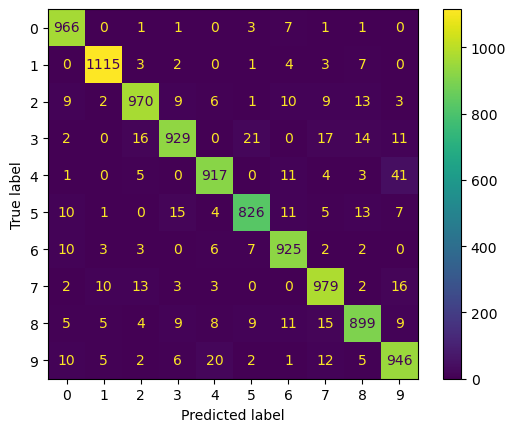

In [21]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), display_labels=range(10))

## Convolutional Neural Networks

Now we will build a convolutional neural network to classify the same images. Convolutional neural networks are a special type of neural network that are designed to work with images. With convolutional layers, a "filter" is learned, which is a small matrix of weights. The filter is applied to each part of the image, and the output is a new image that is a "filtered" version of the original image. The filters are learned during training, and the goal is for the filters to learn to detect certain features of the image, such as edges or corners.

In this way, CNNs can accept 2D images as input, rather than a flattened vector. This allows us to preserve the spatial information of the image, which is important for image classification.

In [22]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Build the model

input = keras.layers.Input(
    shape=(28, 28, 1)
)  # Instead of a flattened vector, we specify the shape of the input to be a 28x28 image with 1 channel (grayscale)

conv1 = Conv2D(32, (3, 3), activation="relu")(
    input
)  # Our first convolutional layer - uses a 3x3 filter of weights to produce 32 filtered images

conv2 = Conv2D(64, (3, 3), activation="relu")(
    conv1
)  # Our second convolutional layer - uses a 3x3 filter of weights to produce 64 filtered images

flatten = Flatten()(
    conv2
)  # Flatten the output of the convolutional layers into a vector, so we can make a prediction

hidden1 = Dense(128, activation="relu")(
    flatten
)  # Our first hidden layer - takes in the flattened output of the convolutional layers, and outputs 128 values

output = Dense(10, activation="softmax")(
    hidden1
)  # Our output layer - takes in the output of the first hidden layer, and outputs 10 values (one for each possible class)

Like before, we just need to compile the model, specifying the optimizer, loss function, and metrics we want to use. We will use the Adam optimizer, the categorical cross-entropy loss function, and the accuracy metric.

In [23]:
model = keras.models.Model(inputs=input, outputs=output)
model.summary()

# Visualize the model
keras.utils.plot_model(model, show_shapes=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               4718720   
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 4738826 (18.08 MB)
Trainable params: 4738826 

In [24]:
# Compile the model - this time we will use adam, a more advanced optimizer based on stochastic gradient descent
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [25]:
# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5


2023-11-07 16:20:15.644639: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-07 16:20:15.708227: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1688/1688 [==============================] - 8s 3ms/step - loss: 0.1196 - accuracy: 0.9637 - val_loss: 0.0452 - val_accuracy: 0.9860
Epoch 2/5
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0394 - accuracy: 0.9877 - val_loss: 0.0452 - val_accuracy: 0.9862
Epoch 3/5
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0216 - accuracy: 0.9928 - val_loss: 0.0544 - val_accuracy: 0.9857
Epoch 4/5
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0153 - accuracy: 0.9950 - val_loss: 0.0418 - val_accuracy: 0.9895
Epoch 5/5
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0102 - accuracy: 0.9968 - val_loss: 0.0380 - val_accuracy: 0.9890


In [26]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {loss:.2f}")
print(f"Test accuracy: {accuracy*100:.2f}%")

313/313 [==============================] - 1s 2ms/step - loss: 0.0468 - accuracy: 0.9872
Test loss: 0.05
Test accuracy: 98.72%


Between swapping out stochastic gradient descent for Adam, and using convolutional layers instead of dense layers, we were able to improve our accuracy by 1.5%!

Next, we are going to introduce a couple of 'Callbacks'. These are functions that are called during training. We will use two callbacks: EarlyStopping and ModelCheckpoint. 

EarlyStopping will stop the training process if the validation loss stops improving. This means that we don't have to specify the number of epochs ahead of time - the model will train until it stops improving, and then stop automatically.

ModelCheckpoint will save the best model (the one with the lowest validation loss) to a file. This is useful because we can then load the best model and evaluate it on the test set.

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor="val_loss", patience=5
)  # Stop training if the validation loss hasn't improved in 5 epochs

model_checkpoint = ModelCheckpoint(
    "best_model", monitor="val_loss", save_best_only=True
)  # Save the model with the lowest validation loss to a folder called 'best_model'

This part is the same as before, but we want a new model so we'll run it again:

In [28]:
input = keras.layers.Input(shape=(28, 28, 1))
conv1 = Conv2D(32, (3, 3), activation="relu")(input)
pool1 = MaxPooling2D((2, 2))(
    conv1
)  # Add a pooling layer to reduce the size of the output of the convolutional layer - this will speed up training
conv2 = Conv2D(64, (3, 3), activation="relu")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)  # Add another pooling layer
flatten = Flatten()(pool2)
hidden1 = Dense(128, activation="relu")(flatten)
output = Dense(10, activation="softmax")(hidden1)
model = keras.models.Model(inputs=input, outputs=output)

And now we can train:

In [29]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model with callbacks
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/50
1688/1688 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9575INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1688/1688 [==============================] - 7s 4ms/step - loss: 0.1376 - accuracy: 0.9575 - val_loss: 0.0468 - val_accuracy: 0.9867
Epoch 2/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0438 - accuracy: 0.9859 - val_loss: 0.0468 - val_accuracy: 0.9875
Epoch 3/50
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0305 - accuracy: 0.9904 - val_loss: 0.0488 - val_accuracy: 0.9865
Epoch 4/50
1675/1688 [============================>.] - ETA: 0s - loss: 0.0213 - accuracy: 0.9931INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1688/1688 [==============================] - 5s 3ms/step - loss: 0.0213 - accuracy: 0.9931 - val_loss: 0.0396 - val_accuracy: 0.9898
Epoch 5/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0156 - accuracy: 0.9948 - val_loss: 0.0417 - val_accuracy: 0.9897
Epoch 6/50
1669/1688 [============================>.] - ETA: 0s - loss: 0.0129 - accuracy: 0.9956INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1688/1688 [==============================] - 5s 3ms/step - loss: 0.0130 - accuracy: 0.9955 - val_loss: 0.0379 - val_accuracy: 0.9913
Epoch 7/50
1688/1688 [==============================] - 4s 3ms/step - loss: 0.0100 - accuracy: 0.9966 - val_loss: 0.0455 - val_accuracy: 0.9895
Epoch 8/50
1688/1688 [==============================] - 4s 3ms/step - loss: 0.0074 - accuracy: 0.9974 - val_loss: 0.0400 - val_accuracy: 0.9913
Epoch 9/50
1688/1688 [==============================] - 4s 3ms/step - loss: 0.0074 - accuracy: 0.9976 - val_loss: 0.0558 - val_accuracy: 0.9897
Epoch 10/50
1688/1688 [==============================] - 4s 3ms/step - loss: 0.0070 - accuracy: 0.9977 - val_loss: 0.0399 - val_accuracy: 0.9908
Epoch 11/50
1688/1688 [==============================] - 4s 3ms/step - loss: 0.0054 - accuracy: 0.9981 - val_loss: 0.0476 - val_accuracy: 0.9908


In [30]:
# Load the best model
model = keras.models.load_model("best_model")

In [31]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {loss:.2f}")
print(f"Test accuracy: {accuracy*100:.2f}%")

313/313 [==============================] - 0s 1ms/step - loss: 0.0382 - accuracy: 0.9884
Test loss: 0.04
Test accuracy: 98.84%


When we train a model, we can also access the history of the training process. This includes the loss and accuracy on the training and validation sets at each epoch. We can use this to plot the training and validation loss over time, which can help us diagnose problems with our model.

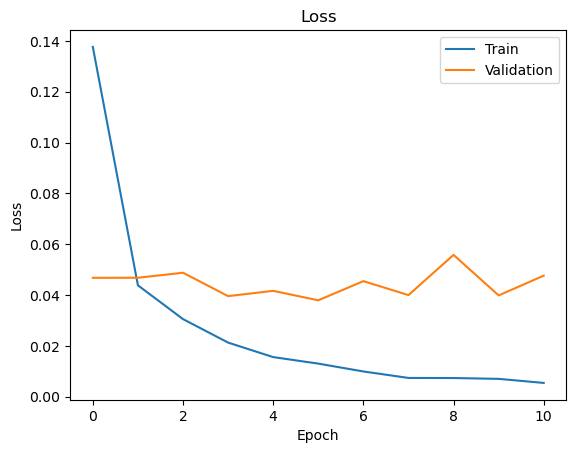

In [32]:
# Plot the training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.show()

Let's take a look at some of the incorrect predictions for this model:

313/313 [==============================] - 0s 967us/step


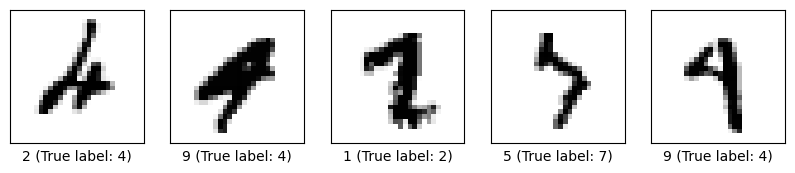

In [33]:
# Visualize the first 5 incorrect predictions
predictions = model.predict(x_test)
incorrect_indices = np.nonzero(
    np.argmax(predictions, axis=1) != np.argmax(y_test, axis=1)
)[0]
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[incorrect_indices[i]], cmap=plt.cm.binary)
    plt.xlabel(
        f"{np.argmax(predictions[incorrect_indices[i]])} (True label: {np.argmax(y_test[incorrect_indices[i]])})"
    )
plt.show()

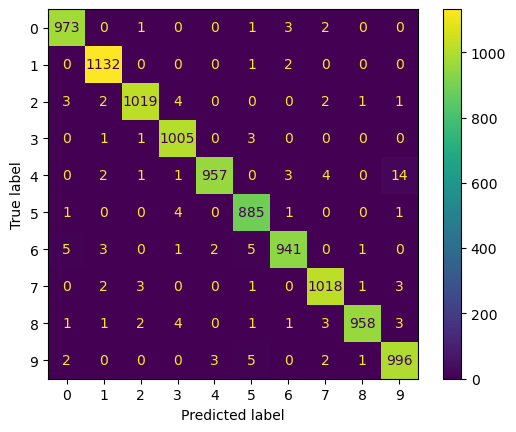

In [34]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), display_labels=range(10))

## Your Turn

Now it's your turn to build a neural network! We will use the CIFAR-10 dataset, which consists of 60,000 32x32 color images in 10 classes. We will build a neural network to classify these images.

First, we will download the dataset:

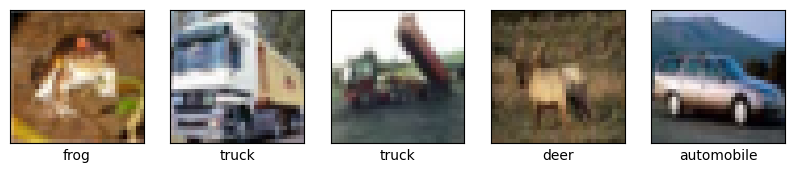

In [35]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# Preview the first 5 images
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [36]:
# Normalize the data
x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

In [37]:
# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

Using the example code above, build a model that can classify these images. You can copy directly one of the model definitions from above, but if you feel like it, you can also extend the network further. You can get more information about available layers and other options in the [Keras documentation](https://keras.io/).

Note that there are two key differences between our MNIST images of digits, and these CIFAR images: 
- The CIFAR images are in color, so they have 3 channels instead of 1.
- The CIFAR images are 32x32 pixels, instead of 28x28.

This means that instead of each image having a shape of (28,28,1), indicating a 28x28 image with 1 channel, each image will have a shape of (32,32,3), indicating a 32x32 image with 3 channels. You will need to change the input shape of your model accordingly.

In [38]:
input = keras.layers.Input(shape=(32, 32, 3))
conv1 = Conv2D(32, (3, 3), activation="relu")(input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation="relu")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
flatten = Flatten()(pool2)
hidden1 = Dense(128, activation="relu")(flatten)
output = Dense(10, activation="softmax")(hidden1)
model = keras.models.Model(inputs=input, outputs=output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 2304)              0   

In [40]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [41]:
# Train the model with callbacks
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/50
1407/1407 [==============================] - 5s 3ms/step - loss: 1.4491 - accuracy: 0.4792 - val_loss: 1.2530 - val_accuracy: 0.5610
Epoch 2/50
1407/1407 [==============================] - 4s 3ms/step - loss: 1.1040 - accuracy: 0.6110 - val_loss: 1.0295 - val_accuracy: 0.6440
Epoch 3/50
1407/1407 [==============================] - 12s 8ms/step - loss: 0.9611 - accuracy: 0.6627 - val_loss: 0.9707 - val_accuracy: 0.6686
Epoch 4/50
1407/1407 [==============================] - 4s 3ms/step - loss: 0.8578 - accuracy: 0.7025 - val_loss: 0.8973 - val_accuracy: 0.6878
Epoch 5/50
1407/1407 [==============================] - 4s 3ms/step - loss: 0.7751 - accuracy: 0.7291 - val_loss: 0.8957 - val_accuracy: 0.6942
Epoch 6/50
1407/1407 [==============================] - 4s 3ms/step - loss: 0.6990 - accuracy: 0.7550 - val_loss: 0.9073 - val_accuracy: 0.6972
Epoch 7/50
1407/1407 [==============================] - 4s 3ms/step - loss: 0.6276 - accuracy: 0.7816 - val_loss: 0.8949 - val_accuracy

In [42]:
# Code to evaluate model performance
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
y_test_max = np.argmax(y_test, axis=1)

print(classification_report(y_test_max, predictions, target_names=class_names))

313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

    airplane       0.75      0.70      0.72      1000
  automobile       0.84      0.78      0.81      1000
        bird       0.61      0.54      0.57      1000
         cat       0.51      0.41      0.45      1000
        deer       0.71      0.53      0.61      1000
         dog       0.52      0.61      0.57      1000
        frog       0.73      0.78      0.75      1000
       horse       0.59      0.83      0.69      1000
        ship       0.77      0.82      0.80      1000
       truck       0.76      0.78      0.77      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.67     10000
weighted avg       0.68      0.68      0.67     10000


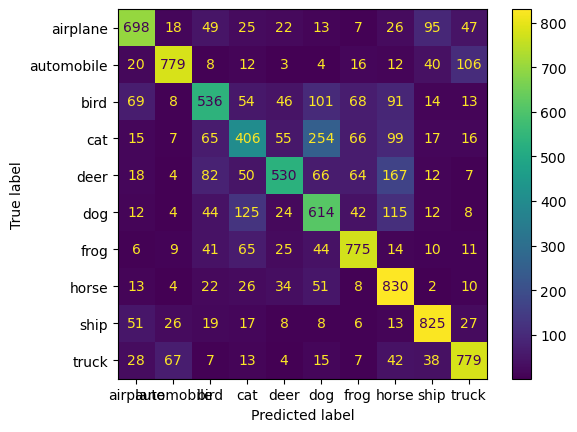

In [44]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_max, predictions, display_labels=class_names)